# ARHGAP5 cis comparison


## Step 1: Library Imports

Run this cell to import the necessary libraries

In [39]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import re
import sys 
sys.path.append('C:\\Users\\brittany henderson\\GitHub\\GBM_for_CPTAC\\')
import cis_functions as f

import cptac
import cptac.utils as u

In [2]:
def wrap_ttest_return_all(df, label_column, comparison_columns, total_tests, alpha=.05):
    try:
        #Verify precondition that label column exists and has exactly 2 unique values
        label_values = df[label_column].unique()
        if len(label_values) != 2:
            print("Incorrectly Formatted Dataframe! Label column must have exactly 2 unique values.")
            return None
        
        #Partition dataframe into two sets, one for each of the two unique values from the label column
        partition1 = df.loc[df[label_column] == label_values[0]]
        partition2 = df.loc[df[label_column] == label_values[1]]
        
        #Determine the number of real valued columns on which we will do t-tests
        #sites = len(comparison_columns.columns)
        number_of_comparisons = total_tests # ? phospho sites or num freq mut genes doing cis comp
        
        #Use a bonferroni correction to adjust for multiple testing by altering the p-value needed for acceptance
        bonferroni_cutoff = alpha/number_of_comparisons
        
        #Store all comparisons with their p-values in a dictionary
        all_comparisons = {}
        
        #Loop through each comparison column, perform the t-test, and determine whether it meets the significance cutoff'''
        for column in comparison_columns:
            stat, pval = scipy.stats.ttest_ind(partition1[column].dropna(axis=0), partition2[column].dropna(axis=0))
            all_comparisons[column] = pval
    
        #Sort dictionary to list smallest p-values first
        sorted_comparisons = sorted(all_comparisons.items(), key=lambda kv: kv[1])
        #Format as a dataframe and return to caller
        all_comparisons_df = pd.DataFrame.from_dict(sorted_comparisons)
        all_comparisons_df.columns = ['Comparison', 'P_Value']
        
                                               
        all_comparisons_sig_col = f.add_significance_col(all_comparisons_df, number_of_comparisons)
        return all_comparisons_sig_col
                                
    except:
        print("Incorrectly Formatted Dataframe!")
        return None


## Step 2: Find the mutation frequency of the gene of interest

In [3]:
#cptac.download(dataset='ccrcc', version='0.0')
brain = cptac.Gbm()
desired_cutoff = 0.05
gene = 'ARHGAP5'

In [ ]:
freq_mut = u.get_frequently_mutated(brain, cutoff = desired_cutoff)
freq_mut.loc[freq_mut['Gene'] == gene]

## Step 3: cis comparisons for omics 

Determine if the DNA mutation has an effect on the omics measurement. In order to do this, we have a few steps in code. These steps are found in the format_cis_comparison_data function.
1. get a table with both the omics and mutation data for tumors
2. get a binary column from the mutation data to separate our samples
3. format data frame to be used in the T-test
4. send data to the T-test.

The format_cis_comparison_data does the first 3 steps (for dataframes with multi-indexes).

# Transcriptomics cis comparison

Transcriptomics: Mutated and Wildtype

In [12]:
cis_tests = 20
# Step 1 - Create dataframe in order to do comparisons with wrap_ttest - drop 
omics_name = 'transcriptomics'
omics_and_mutations = brain.join_omics_to_mutations(
    mutations_genes = gene, omics_df_name = omics_name, omics_genes = gene)

# Step 2 - Create binary column 
omics_and_mutations['binary_mutations'] = np.where(
            omics_and_mutations[gene+'_Mutation_Status'] == 'Wildtype_Tumor', 'Wildtype', 'Mutated')

# Step 3 - Format the dataframe correctly for the T-test(just omics and binary columns for tumors)
flatten_omics_and_mut = brain.reduce_multiindex(omics_and_mutations, levels_to_drop=1, flatten=True) #single col labels
tumors = flatten_omics_and_mut[flatten_omics_and_mut.Sample_Status == 'Tumor'] #drop Normal samples
columns_to_drop = [gene+"_Mutation", gene+"_Location", gene+"_Mutation_Status", "Sample_Status"]
trans_mut_status = tumors.drop(columns_to_drop, axis = 1)

In [13]:
# Step 4 - T-test
trans_col_list = [gene+'_transcriptomics']
trans_col = gene+'_transcriptomics'
#trans_mut_status = format_cis_comparison_data(brain, 'transcriptomics', gene)

print("Doing t-test comparison for mutation status")
transcrpt_results = wrap_ttest_return_all(trans_mut_status, 'binary_mutations', trans_col_list, cis_tests)
transcrpt_results = transcrpt_results.rename(index = {0: "Mutated/Wildtype"})
transcrpt_results

Doing t-test comparison for mutation status


,Comparison,P_Value,Significant
Mutated/Wildtype,ARHGAP5_transcriptomics,0.675463,False


This p-value is not significant because of multiple hypothesis testing. Other notebooks test the rest of the frequently mutated genes. 

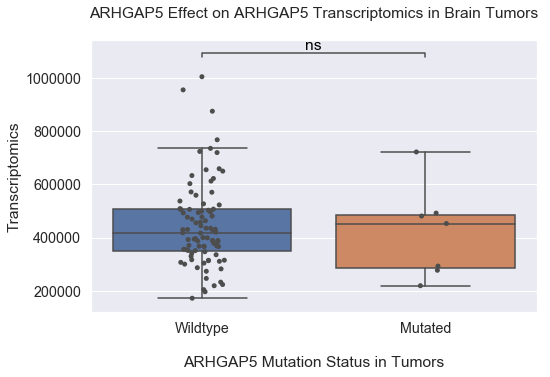

In [14]:
#f.cis_plot(trans_mut_status, gene, 'transcriptomics', transcrpt_results)
plt.rcParams['figure.figsize']=(8,5)
sns.set(font_scale = 1.3)
cis_boxplot = sns.boxplot(data = trans_mut_status, x = 'binary_mutations',
                          y = trans_col, order = ['Wildtype', 'Mutated'], showfliers = False)  
cis_boxplot.set_title(gene + " Effect on " + gene +" Transcriptomics in Brain Tumors\n")
cis_boxplot = sns.stripplot(data= trans_mut_status, x = 'binary_mutations',
                            y = trans_col,jitter = True, color = ".3", order = ['Wildtype', 'Mutated'])
cis_boxplot.set(xlabel = "\n"+gene + " Mutation Status in Tumors", ylabel = 'Transcriptomics')
cis_boxplot.set_xticklabels(cis_boxplot.get_xticklabels())

mut_pval_symbol = f.get_pval_symbol(transcrpt_results)
f.format_pval_annotation(mut_pval_symbol, x1 = 0, x2 = 1, line_start = 1080000, line_height = 15000)

plt.show()
plt.clf()
plt.close()

Transcriptomics: Missense and Truncation

In [16]:
# select all wildtype from earlier -add to mut_type binary column
trans_wildtype = trans_mut_status.loc[trans_mut_status['binary_mutations'] == 'Wildtype'] 
trans_mut_type = f.get_missense_truncation_comparison(brain, 'transcriptomics', gene)
trans_mut_and_wildtype = trans_mut_type.append(trans_wildtype, sort=False) # use for graph

In [17]:
# compare missense and wildtype
miss_wt = trans_mut_and_wildtype.loc[trans_mut_and_wildtype['binary_mutations'] != 'Truncation']
print("Doing t-test comparison for missense and wildtype")
trans_results_miss = wrap_ttest_return_all(miss_wt, 'binary_mutations', trans_col_list, cis_tests)
trans_results_miss = trans_results_miss.rename(index = {0: "Missense/Wildtype"})

# compare truncation and wildtype
trunc_wt = trans_mut_and_wildtype.loc[trans_mut_and_wildtype['binary_mutations'] != 'Missense']
print("Doing t-test comparison for truncation and wildtype")
trans_results_trunc = wrap_ttest_return_all(trunc_wt, 'binary_mutations', trans_col_list, cis_tests)
trans_results_trunc = trans_results_trunc.rename(index = {0: "Truncation/Wildtype"})

trans_results_miss_trunc = trans_results_miss.append(trans_results_trunc)
trans_results_miss_trunc

Doing t-test comparison for missense and wildtype
Doing t-test comparison for truncation and wildtype


,Comparison,P_Value,Significant
Missense/Wildtype,ARHGAP5_transcriptomics,0.561910,False
Truncation/Wildtype,ARHGAP5_transcriptomics,0.291038,False


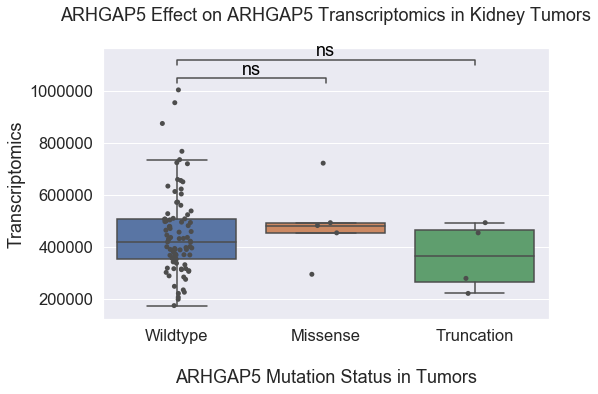

In [30]:
#f.cis_plot(trans_mut_and_wildtype, gene, 'transcriptomics', trans_results_miss_trunc)
plt.rcParams['figure.figsize']=(8,5)
sns.set(font_scale = 1.5)
cis_boxplot = sns.boxplot(data = trans_mut_and_wildtype, x = 'binary_mutations',
                          y = trans_col, order = ['Wildtype', 'Missense', 'Truncation'], showfliers = False)  
cis_boxplot.set_title(gene + " Effect on " + gene +" Transcriptomics in Kidney Tumors\n")
cis_boxplot = sns.stripplot(data= trans_mut_and_wildtype, x = 'binary_mutations',
                            y = trans_col,jitter = True, color = ".3", order = ['Wildtype', 'Missense', 'Truncation'])
cis_boxplot.set(xlabel = "\n"+gene + " Mutation Status in Tumors", ylabel = 'Transcriptomics')
cis_boxplot.set_xticklabels(cis_boxplot.get_xticklabels())

# Missense
miss_pval = trans_results_miss_trunc.loc[trans_results_miss_trunc.index == "Missense/Wildtype"]
miss_pval_symbol = f.get_pval_symbol(miss_pval)
f.format_pval_annotation(miss_pval_symbol, x1 = 0, x2 = 1, line_start = 1030000, line_height = 20000)

# Truncation 
trunc_pval = trans_results_miss_trunc.loc[trans_results_miss_trunc.index == "Truncation/Wildtype"]
trunc_pval_symbol = f.get_pval_symbol(trunc_pval)
f.format_pval_annotation(miss_pval_symbol, x1 = 0, x2 = 2, line_start = 1100000, line_height = 20000)

plt.show()
plt.clf()
plt.close()

# Proteomics cis comparison

Proteomics: Mutated and Wildtype

In [26]:
# Step 1 - Create dataframe in order to do comparisons with wrap_ttest - drop 
prot_and_mutations = brain.join_omics_to_mutations(
    mutations_genes = gene, omics_df_name = 'proteomics', omics_genes = gene)

# Step 2 - Create binary column 
prot_and_mutations['binary_mutations'] = np.where(
            prot_and_mutations[gene+'_Mutation_Status'] == 'Wildtype_Tumor', 'Wildtype', 'Mutated')

# Step 3 - Format the dataframe correctly for the T-test(just omics and binary columns for tumors)
#flatten_omics_and_mut = brain.reduce_multiindex(omics_and_mutations, levels_to_drop=1, flatten=True) #single col labels
prot_tumors = prot_and_mutations.loc[prot_and_mutations['Sample_Status'] == 'Tumor'] #drop Normal samples
columns_to_drop = [gene+"_Mutation", gene+"_Location", gene+"_Mutation_Status", "Sample_Status"]
prot_mut_status = prot_tumors.drop(columns_to_drop, axis = 1)

In [27]:
#all_genes_cis_comparisons = len(freq_mut) 
all_genes_cis_comparisons = 20
prot_col_list = [gene+'_proteomics']
prot_col = gene+"_proteomics"

# Step 4 - T-test comparing means of mutated vs wildtype effect on cis omics
print("Doing t-test comparison for mutated and wildtype")
prot_results = wrap_ttest_return_all(prot_mut_status, 'binary_mutations', prot_col_list, all_genes_cis_comparisons)
prot_results = prot_results.rename(index = {0: "Mutated/Wildtype"})
prot_results

Doing t-test comparison for mutated and wildtype


,Comparison,P_Value,Significant
Mutated/Wildtype,ARHGAP5_proteomics,0.790511,False


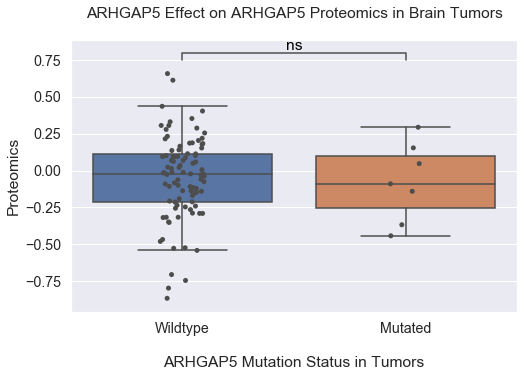

In [36]:
#f.cis_plot(prot_mut_status, gene, "proteomics", prot_results)

plt.rcParams['figure.figsize']=(8,5)
sns.set(font_scale = 1.3)
cis_boxplot = sns.boxplot(data = prot_mut_status, x = 'binary_mutations',
                          y = prot_col, order = ['Wildtype', 'Mutated'], showfliers = False)  
cis_boxplot.set_title(gene + " Effect on " + gene +" Proteomics in Brain Tumors\n")
cis_boxplot = sns.stripplot(data= prot_mut_status, x = 'binary_mutations',
                            y = prot_col,jitter = True, color = ".3", order = ['Wildtype', 'Mutated'])
cis_boxplot.set(xlabel = "\n"+gene + " Mutation Status in Tumors", ylabel = 'Proteomics')
cis_boxplot.set_xticklabels(cis_boxplot.get_xticklabels())

mut_pval_symbol = f.get_pval_symbol(transcrpt_results)
f.format_pval_annotation(mut_pval_symbol, x1 = 0, x2 = 1, line_start = .75, line_height = .05)

plt.show()
plt.clf()
plt.close()

Proteomics: Missense and Truncation compared to wildtype

In [ ]:
import numpy as np
    #get omics data and tumors
    omics_and_mutations = cancer_object.join_omics_to_mutations(
                mutations_genes = gene, omics_df_name = omics_name, omics_genes = gene)
    flatten_omics_and_mutations = cancer_object.reduce_multiindex(omics_and_mutations, levels_to_drop=1, flatten=True)

In [41]:
# Step 1 - Create dataframe in order to do comparisons with wrap_ttest - drop nan values
joined_prot_mut = brain.join_omics_to_mutations(
        mutations_genes = gene, omics_df_name = 'proteomics', omics_genes = gene).dropna()

# Step 2 - binary column
prot_mut_type = f.get_missense_truncation_comparison(brain, joined_prot_mut, gene)
prot_mut_type

InvalidParameterError: Please pass a str for dataframe name parameter. You passed Name        ARHGAP5_proteomics     ARHGAP5_Mutation ARHGAP5_Location  \
Patient_ID                                                             
S001                    0.3530     [Wildtype_Tumor]    [No_mutation]   
S002                   -0.0588     [Wildtype_Tumor]    [No_mutation]   
S003                   -0.1510     [Wildtype_Tumor]    [No_mutation]   
S004                   -0.1410  [Missense_Mutation]        [p.R859W]   
S005                    0.0960     [Wildtype_Tumor]    [No_mutation]   
...                        ...                  ...              ...   
S106                    0.6080    [Wildtype_Normal]    [No_mutation]   
S107                    0.5570    [Wildtype_Normal]    [No_mutation]   
S108                    0.4720    [Wildtype_Normal]    [No_mutation]   
S109                    0.4610    [Wildtype_Normal]    [No_mutation]   
S110                    0.6240    [Wildtype_Normal]    [No_mutation]   

Name       ARHGAP5_Mutation_Status Sample_Status  
Patient_ID                                        
S001                Wildtype_Tumor         Tumor  
S002                Wildtype_Tumor         Tumor  
S003                Wildtype_Tumor         Tumor  
S004               Single_mutation         Tumor  
S005                Wildtype_Tumor         Tumor  
...                            ...           ...  
S106               Wildtype_Normal        Normal  
S107               Wildtype_Normal        Normal  
S108               Wildtype_Normal        Normal  
S109               Wildtype_Normal        Normal  
S110               Wildtype_Normal        Normal  

[110 rows x 5 columns], which is a <class 'pandas.core.frame.DataFrame'>

In [ ]:
prot_wildtype = prot_mut_status.loc[prot_mut_status['binary_mutations'] == 'Wildtype'] # select all wildtype 
prot_mut_and_wildtype = prot_mut_type.append(prot_wildtype, sort=False) # use for graph

# compare missense and wildtype
prot_miss_wt = prot_mut_and_wildtype.loc[prot_mut_and_wildtype['binary_mutations'] != 'Truncation']
print("Doing t-test comparison for missense and wildtype")
prot_results_miss = wrap_ttest_return_all(prot_miss_wt, 'binary_mutations', prot_col_list, cis_tests)
prot_results_miss = prot_results_miss.rename(index = {0: "Missense/Wildtype"})

# compare truncation and wildtype
prot_trunc_wt = prot_mut_and_wildtype.loc[prot_mut_and_wildtype['binary_mutations'] != 'Missense']
print("Doing t-test comparison for truncation and wildtype")
prot_results_trunc = wrap_ttest_return_all(prot_trunc_wt, 'binary_mutations', prot_col_list, cis_tests)
prot_results_trunc = prot_results_trunc.rename(index = {0: "Truncation/Wildtype"})

prot_results_miss_trunc = prot_results_miss.append(prot_results_trunc)
prot_results_miss_trunc

# Phosphoproteomics cis comparison

Phosphoproteomics: Mutated and Wildtype

In [96]:
# Step 1 - Create dataframe in order to do comparisons with wrap_ttest
phospho_and_mut = brain.join_omics_to_mutations(
    mutations_genes = gene, omics_df_name = 'phosphoproteomics', omics_genes = gene)
flatten_phospho_and_mut = brain.reduce_multiindex(phospho_and_mut, levels_to_drop=1, flatten=True)#reduce multi columns

# Step 2 - Create the binary column needed to do the comparison
flatten_phospho_and_mut['binary_mutations'] = flatten_phospho_and_mut[gene+'_Mutation_Status'].apply(
    lambda x: 'Wildtype' if x == 'Wildtype_Tumor' else 'Mutated')

# Step 3 - Format
phospho_tumors = flatten_phospho_and_mut.query('Sample_Status != "Normal"') # drop Normal samples (warning with .loc)
columns_to_drop = [gene+"_Mutation", gene+"_Location", gene+"_Mutation_Status", "Sample_Status"]
binary_phospho = phospho_tumors.drop(columns_to_drop, axis = 1)
only_phospho = binary_phospho.drop('binary_mutations', axis = 1)

In [105]:
# Use al.wrap_ttest for many columns of phospho data
phos_col_list = list(only_phospho.columns)
phospho_sites = len(phos_col_list)

# Step 4 - T-test comparing means of mutated vs wildtype effect on cis omics
print("Doing t-test comparison for mutation status")
phos_pval_results = wrap_ttest_return_all(binary_phospho, 'binary_mutations', phos_col_list, total_tests=phospho_sites)
phos_pval_results = phos_pval_results.rename(index = {0: "Mutated/Wildtype"})
phos_pval_results

Doing t-test comparison for mutation status


,Comparison,P_Value,Significant
Mutated/Wildtype,ARHGAP5_phosphoproteomics_GS*EEDPLLSPVETWK,0.054116,False
1,ARHGAP5_phosphoproteomics_HNLDVVS*PIPANK,0.088724,False
2,ARHGAP5_phosphoproteomics_IRNSFVNNT*QGDEENGFSDR,0.125453,False
3,ARHGAP5_phosphoproteomics_RTHS*DASDDEAFTTSK,0.285242,False
4,ARHGAP5_phosphoproteomics_GGIDNPAITS*DQELDDKK,0.290142,False
5,ARHGAP5_phosphoproteomics_THS*DASDDEAFTTSK,0.337019,False
6,ARHGAP5_phosphoproteomics_RTHS*DAS*DDEAFTTSK,0.345799,False
7,ARHGAP5_phosphoproteomics_NSFVNNTQGDEENGFS*DRTSK,0.349662,False
8,ARHGAP5_phosphoproteomics_ESTHQSEDVFLPS*PR,0.395642,False
9,ARHGAP5_phosphoproteomics_NSFVNNTQGDEENGFSDRTS*K,0.420519,False


Graph

In [107]:
# Create data frame with all significant phospho sites in order to graph
phospho_list = list(phos_pval_results['Comparison'])
phospho_df = pd.melt(binary_phospho, id_vars = 'binary_mutations', 
            value_vars = phospho_list, var_name = 'specific_phospho', value_name = 'phosphoproteomics')
phospho_df.replace(to_replace = '_phosphoproteomics', value = '', 
                        inplace = True, regex = True) # shorten column names

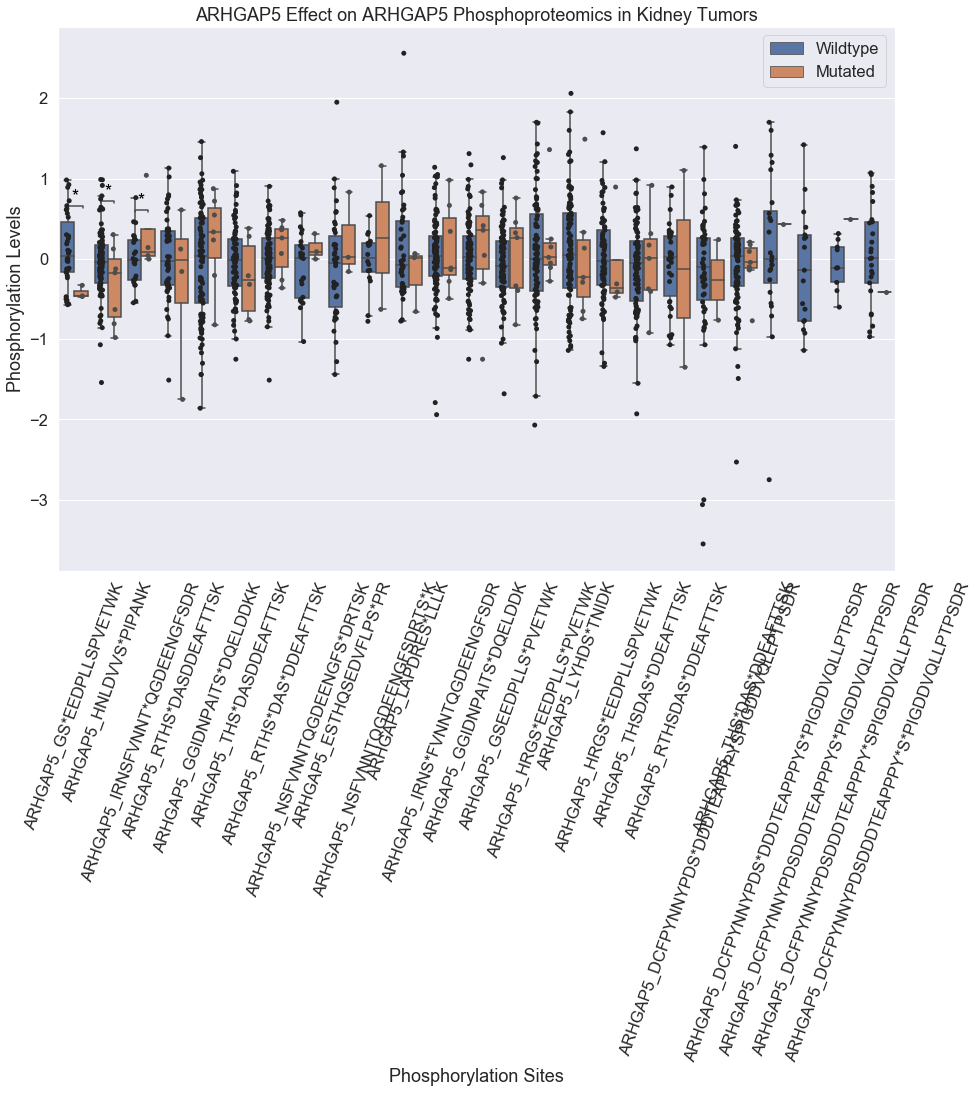

In [110]:
plt.rcParams['figure.figsize']=(15,10) #size of plot
sns.set(font_scale = 1.5)

cis_boxplot = sns.boxplot(data = phospho_df, x = 'specific_phospho', y = 'phosphoproteomics', hue = 'binary_mutations',
                             hue_order = ["Wildtype","Mutated"], showfliers = False) 
cis_boxplot.set_title(gene + " Effect on " + gene + " Phosphoproteomics in Kidney Tumors")
cis_boxplot = sns.stripplot(data = phospho_df, x = 'specific_phospho', y = 'phosphoproteomics', hue = 'binary_mutations',
                               hue_order = ["Wildtype","Mutated"], jitter = True, color = ".3", dodge = True)
cis_boxplot.set(xlabel = 'Phosphorylation Sites', ylabel = "Phosphorylation Levels")
cis_boxplot.set_xticklabels(cis_boxplot.get_xticklabels(),rotation=70)

# format legend
handles, labels = cis_boxplot.get_legend_handles_labels()
plt.legend(handles[0:2], labels[0:2])

# pval annotations for 
f.format_pval_annotation('*', x1 = -.2, x2 = .25, line_start = .63, line_height = .03)
# pval annotations for 
f.format_pval_annotation('*', x1 = .8, x2 = 1.2, line_start = .69, line_height = .03)

f.format_pval_annotation('*', x1 = 1.8, x2 = 2.2, line_start = .58, line_height = .03)

plt.show()
plt.clf()
plt.close()


Phosphoproteomics: Missense and Truncation

In [114]:
# select all wildtype from earlier -add to mut_type binary column
phos_wildtype = binary_phospho.loc[binary_phospho['binary_mutations'] == 'Wildtype'] 

phos_mut_type = get_missense_truncation_comparison(brain, 'phosphoproteomics', gene)
phos_mut_and_wildtype = phos_mut_type.append(phos_wildtype, sort=True) 
#NON-CODING

In [116]:
phos_col_list = list(only_phospho.columns)
# compare missense and wildtype
miss_wt = phos_mut_and_wildtype.loc[phos_mut_and_wildtype['binary_mutations'] != 'Truncation']
print("Doing t-test comparison for missense and wildtype\n")
phos_results_miss = u.wrap_ttest(miss_wt, 'binary_mutations', phos_col_list)
print(phos_results_miss)

# compare truncation and wildtype 
trunc_wt = phos_mut_and_wildtype.loc[phos_mut_and_wildtype['binary_mutations'] != 'Missense']
print("\n\nDoing t-test comparison for truncation and wildtype\n")
phos_results_trunc = u.wrap_ttest(trunc_wt, 'binary_mutations', phos_col_list)
print(phos_results_trunc)

Doing t-test comparison for missense and wildtype

No significant comparisons.
None


Doing t-test comparison for truncation and wildtype

No significant comparisons.
None


Graph Missense and Truncation

In [120]:
# Create data frame with all significant phospho sites in order to graph
phos_mut_type_df = pd.melt(phos_mut_and_wildtype, id_vars = 'binary_mutations', 
            value_vars = phos_col_list, var_name = 'specific_phospho', value_name = 'phosphoproteomics')
phos_mut_type_df.replace(to_replace = '_phosphoproteomics*.', value = '', 
                        inplace = True, regex = True) # shorten column names
#sig_phospho_df.dropna(axis=0)

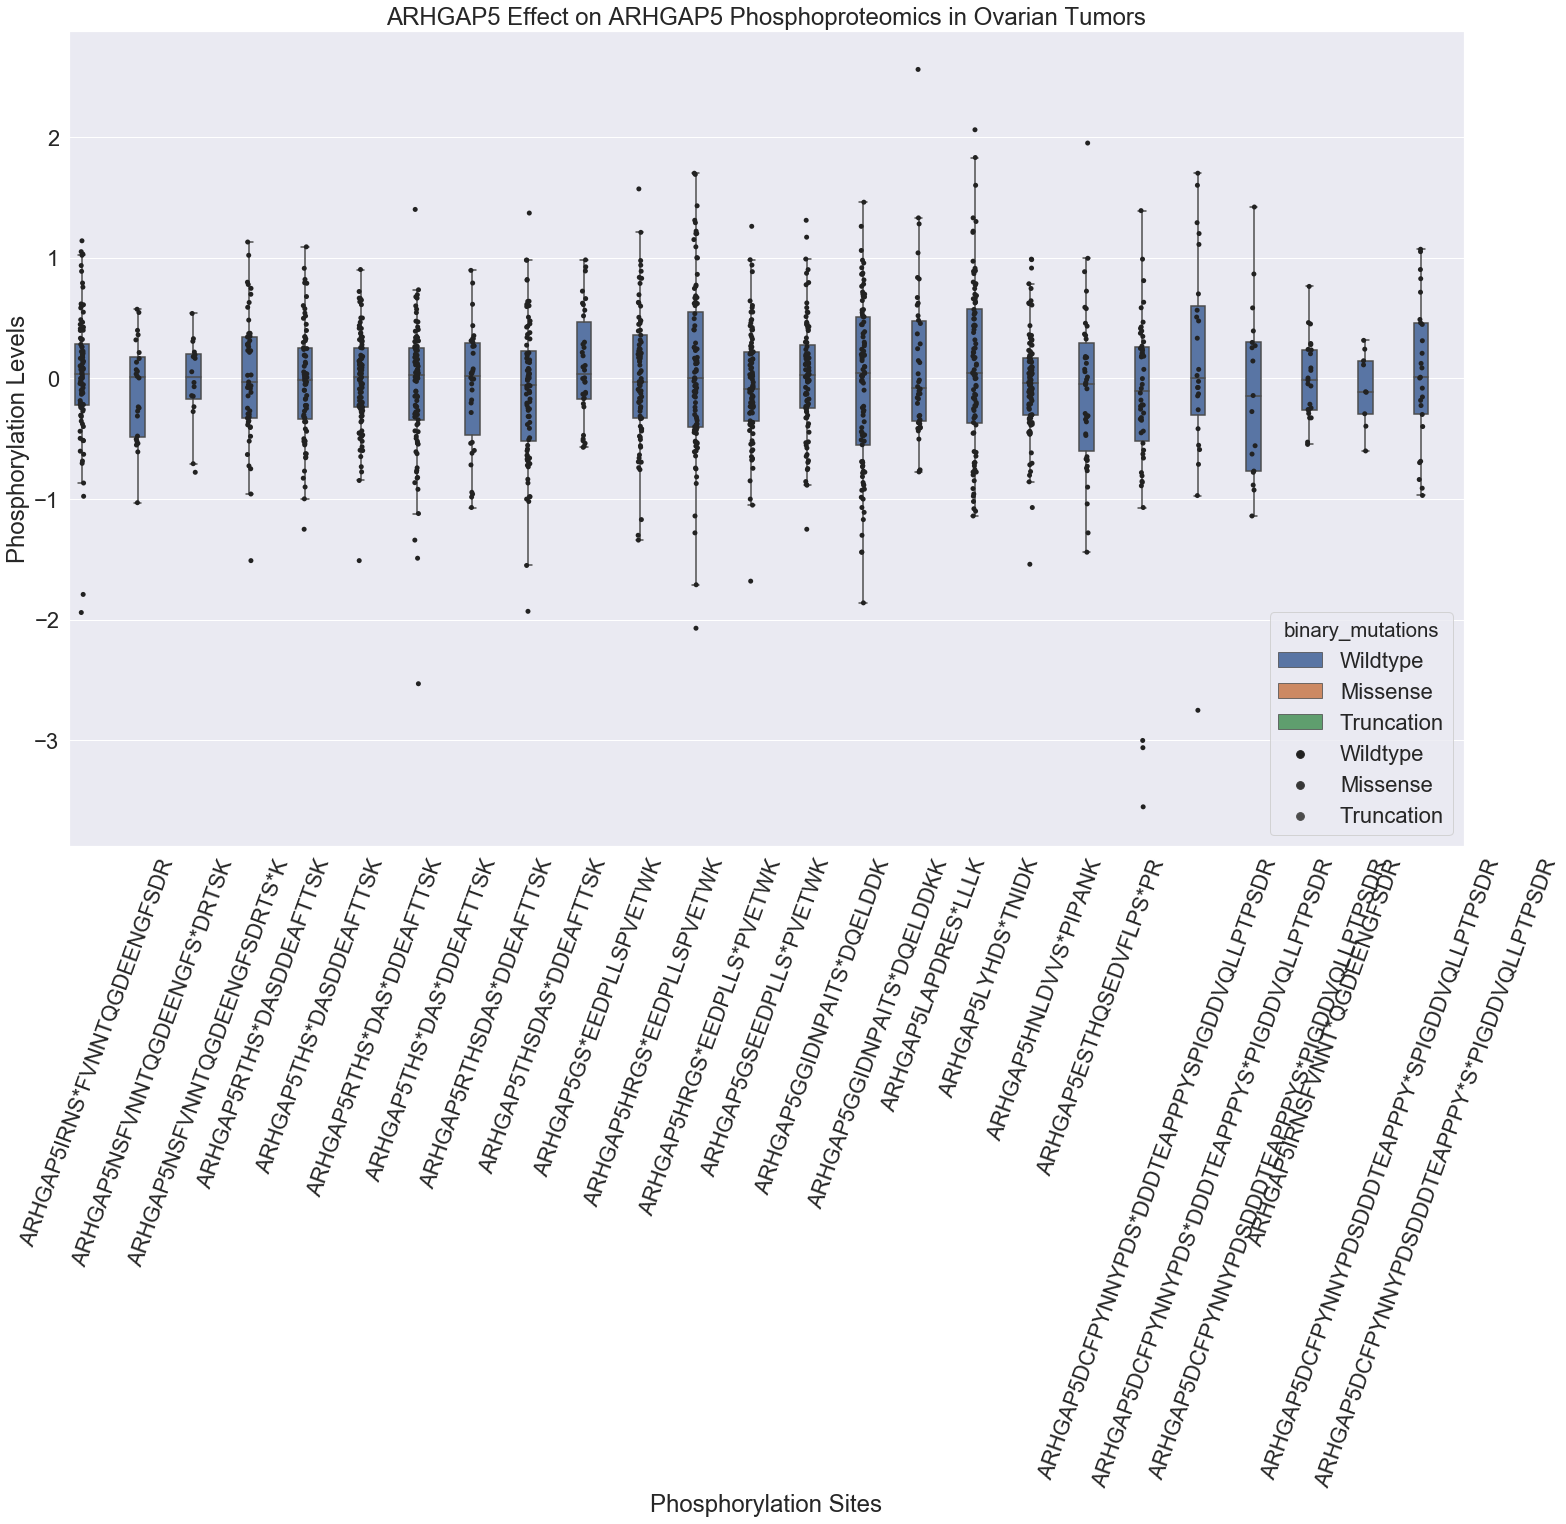

In [121]:
plt.rcParams['figure.figsize']=(25,15) #size of plot
sns.set(font_scale = 2)
phos_cis_boxplot = sns.boxplot(data = phos_mut_type_df, x = 'specific_phospho', y = 'phosphoproteomics', hue = 'binary_mutations',
                             hue_order = ["Wildtype","Missense","Truncation"], showfliers = False)  
phos_cis_boxplot.set_title(gene + " Effect on " + gene + " Phosphoproteomics in Ovarian Tumors")
phos_cis_boxplot = sns.stripplot(data = phos_mut_type_df, x = 'specific_phospho', y = 'phosphoproteomics', hue = 'binary_mutations',
                               hue_order = ["Wildtype","Missense","Truncation"], jitter = True, color = ".3", dodge = True)
phos_cis_boxplot.set(xlabel = 'Phosphorylation Sites', ylabel = "Phosphorylation Levels")
phos_cis_boxplot.set_xticklabels(phos_cis_boxplot.get_xticklabels(),rotation = 70)
plt.show()
plt.clf()
plt.close()

# Analysis of Results

Acetylproteomics not included in the Gbm dataset.